# Exploratory/Statistical Analysis task

_by PK

In [ ]:
try:
    import shap
    import eli5
except Exception as e:
    !pip install eli5 shap -q
finally:
    import eli5
    import shap 

## Dataset

Before beginning the analysis, we will load and view the dataset, and perform some initial cleaning.

* View the dataset info:

In [3]:
# load libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)
%matplotlib inline
sns.set_context('notebook')
sns.set_style('whitegrid')
sns.set_palette('Blues_r')

# turn off warnings for final notebook
import warnings
warnings.filterwarnings('ignore')

# load dataset
df = pd.read_csv('https://raw.githubusercontent.com/pk1308/DataRegistry/master/marketing_data.csv')
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 28 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   ID                   2240 non-null   int64 
 1   Year_Birth           2240 non-null   int64 
 2   Education            2240 non-null   object
 3   Marital_Status       2240 non-null   object
 4    Income              2216 non-null   object
 5   Kidhome              2240 non-null   int64 
 6   Teenhome             2240 non-null   int64 
 7   Dt_Customer          2240 non-null   object
 8   Recency              2240 non-null   int64 
 9   MntWines             2240 non-null   int64 
 10  MntFruits            2240 non-null   int64 
 11  MntMeatProducts      2240 non-null   int64 
 12  MntFishProducts      2240 non-null   int64 
 13  MntSweetProducts     2240 non-null   int64 
 14  MntGoldProds         2240 non-null   int64 
 15  NumDealsPurchases    2240 non-null   int64 
 16  NumWeb

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Response,Complain,Country
0,1826,1970,Graduation,Divorced,"$84,835.00",0,0,6/16/14,0,189,104,379,111,189,218,1,4,4,6,1,0,0,0,0,0,1,0,SP
1,1,1961,Graduation,Single,"$57,091.00",0,0,6/15/14,0,464,5,64,7,0,37,1,7,3,7,5,0,0,0,0,1,1,0,CA
2,10476,1958,Graduation,Married,"$67,267.00",0,1,5/13/14,0,134,11,59,15,2,30,1,3,2,5,2,0,0,0,0,0,0,0,US
3,1386,1967,Graduation,Together,"$32,474.00",1,1,5/11/14,0,10,0,1,0,0,0,1,1,0,2,7,0,0,0,0,0,0,0,AUS
4,5371,1989,Graduation,Single,"$21,474.00",1,0,4/8/14,0,6,16,24,11,0,34,2,3,1,2,7,1,0,0,0,0,1,0,SP


* Clean up column names
* Transform selected columns to numeric format:
    - `Income` to float

In [4]:
# clean up column names that contain whitespace
df.columns = df.columns.str.replace(' ', '')

# transform Income column to a numerical
df['Income'] = df['Income'].str.replace('$', '')
df['Income'] = df['Income'].str.replace(',', '').astype('float')

* The cleaned dataset:

In [5]:
df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Response,Complain,Country
0,1826,1970,Graduation,Divorced,84835.0,0,0,6/16/14,0,189,104,379,111,189,218,1,4,4,6,1,0,0,0,0,0,1,0,SP
1,1,1961,Graduation,Single,57091.0,0,0,6/15/14,0,464,5,64,7,0,37,1,7,3,7,5,0,0,0,0,1,1,0,CA
2,10476,1958,Graduation,Married,67267.0,0,1,5/13/14,0,134,11,59,15,2,30,1,3,2,5,2,0,0,0,0,0,0,0,US
3,1386,1967,Graduation,Together,32474.0,1,1,5/11/14,0,10,0,1,0,0,0,1,1,0,2,7,0,0,0,0,0,0,0,AUS
4,5371,1989,Graduation,Single,21474.0,1,0,4/8/14,0,6,16,24,11,0,34,2,3,1,2,7,1,0,0,0,0,1,0,SP


# Section 01: Exploratory Data Analysis

### Are there any null values or outliers? How will you wrangle/handle them?

#### Null Values
* Identify features containing null values:

In [6]:
# null values
df.isnull().sum().sort_values(ascending=False)

Income                 24
ID                      0
NumDealsPurchases       0
Complain                0
Response                0
AcceptedCmp2            0
AcceptedCmp1            0
AcceptedCmp5            0
AcceptedCmp4            0
AcceptedCmp3            0
NumWebVisitsMonth       0
NumStorePurchases       0
NumCatalogPurchases     0
NumWebPurchases         0
MntGoldProds            0
Year_Birth              0
MntSweetProducts        0
MntFishProducts         0
MntMeatProducts         0
MntFruits               0
MntWines                0
Recency                 0
Dt_Customer             0
Teenhome                0
Kidhome                 0
Marital_Status          0
Education               0
Country                 0
dtype: int64

* The feature `Income` contains 24 null values
* Plot this feature to identify best strategy for imputation
    - Findings:
        - Most incomes are distributed between \\$0-\\$100,000, with a few outliers
        - Will impute null values with median value, to avoid effects of outliers on imputation value

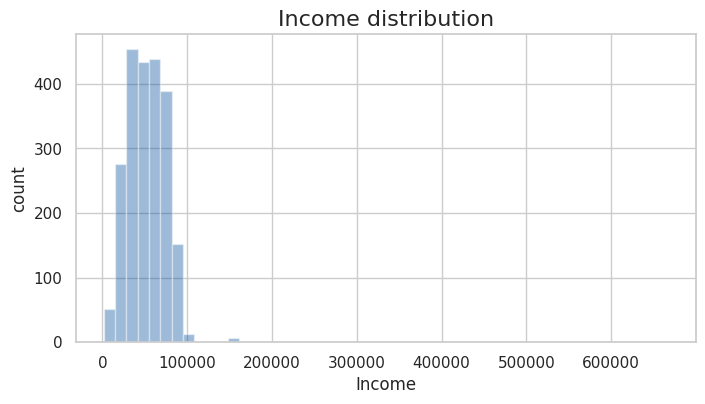

In [7]:
plt.figure(figsize=(8,4))
sns.distplot(df['Income'], kde=False, hist=True)
plt.title('Income distribution', size=16)
plt.ylabel('count');

<Axes: >

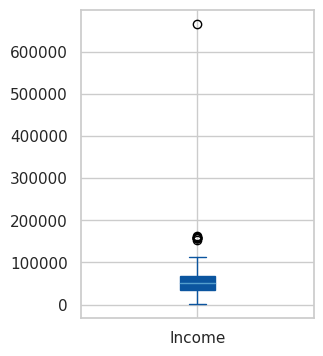

In [8]:
df['Income'].plot(kind='box', figsize=(3,4), patch_artist=True)

* Impute null values in `Income`, using median value (to avoid skewing of the mean due to outliers):

In [9]:
df['Income'] = df['Income'].fillna(df['Income'].median())

#### Outliers

* Identify features containing outliers:
    - Findings: Multiple features contain outliers (see boxplots below), but the only that likely indicate data entry errors are `Year_Birth <= 1900`

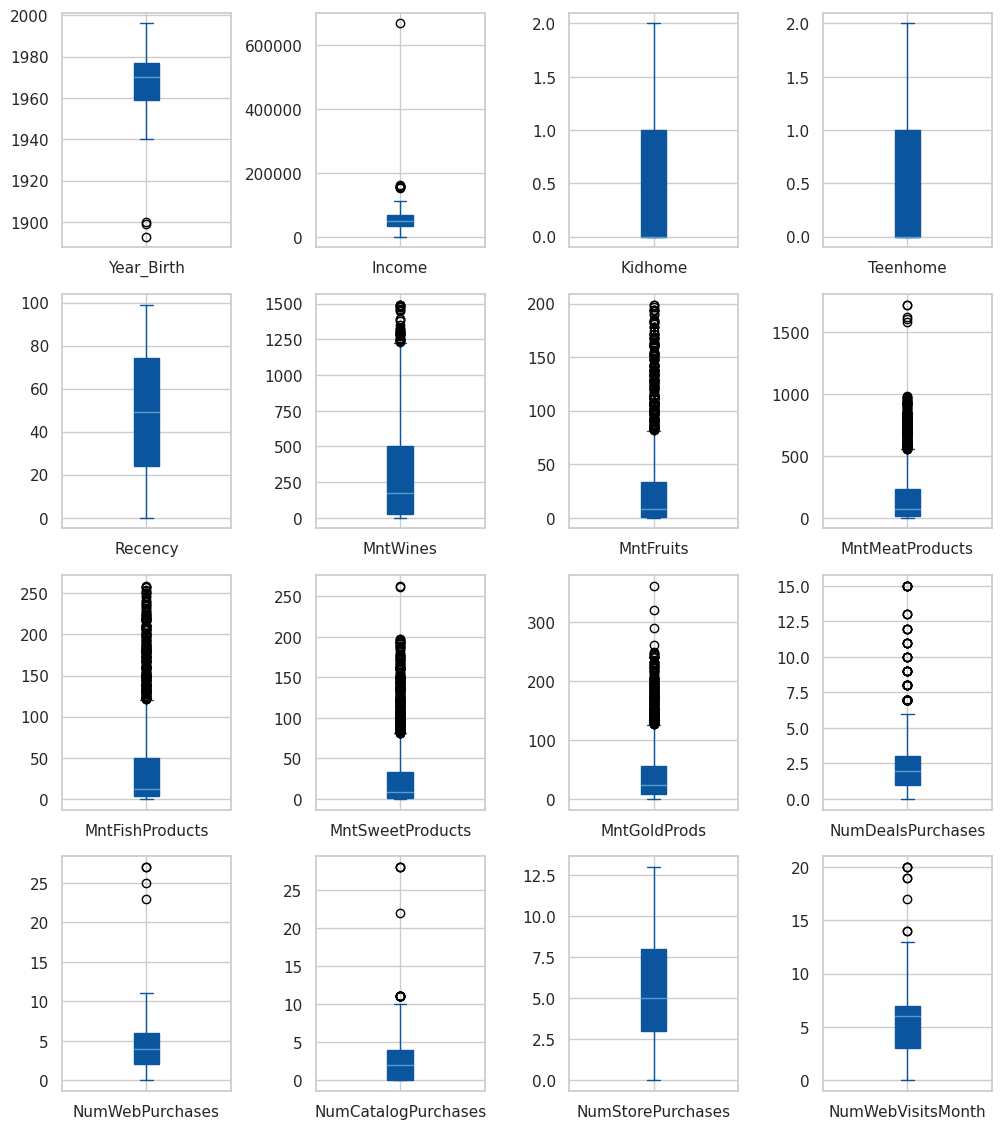

In [10]:
# select columns to plot
df_to_plot = df.drop(columns=['ID', 'AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'Response', 'Complain']).select_dtypes(include=np.number)

# subplots
df_to_plot.plot(subplots=True, layout=(4,4), kind='box', figsize=(12,14), patch_artist=True)
plt.subplots_adjust(wspace=0.5);

* Remove rows where `Year_Birth <= 1900`:

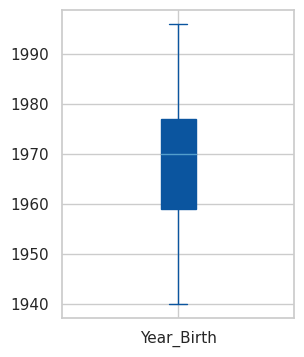

In [11]:
df = df[df['Year_Birth'] > 1900].reset_index(drop=True)

plt.figure(figsize=(3,4))
df['Year_Birth'].plot(kind='box', patch_artist=True);

## Are there any variables that warrant transformations?

* View data types:
    - Findings: The `Dt_Customer` column should be transformed to datetime format

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2237 entries, 0 to 2236
Data columns (total 28 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2237 non-null   int64  
 1   Year_Birth           2237 non-null   int64  
 2   Education            2237 non-null   object 
 3   Marital_Status       2237 non-null   object 
 4   Income               2237 non-null   float64
 5   Kidhome              2237 non-null   int64  
 6   Teenhome             2237 non-null   int64  
 7   Dt_Customer          2237 non-null   object 
 8   Recency              2237 non-null   int64  
 9   MntWines             2237 non-null   int64  
 10  MntFruits            2237 non-null   int64  
 11  MntMeatProducts      2237 non-null   int64  
 12  MntFishProducts      2237 non-null   int64  
 13  MntSweetProducts     2237 non-null   int64  
 14  MntGoldProds         2237 non-null   int64  
 15  NumDealsPurchases    2237 non-null   i

* Transform `Dt_Customer` to datetime:

In [13]:
df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'])

### Are there any useful variables that you can engineer with the given data?

* Review a list of the feature names below, from which we can engineer:
    - The total number of dependents in the home ('Dependents') can be engineered from the sum of 'Kidhome' and 'Teenhome'
    - The year of becoming a customer ('Year_Customer') can be engineered from 'Dt_Customer'
    - The total amount spent ('TotalMnt') can be engineered from the sum of all features containing the keyword 'Mnt'
    - The total purchases ('TotalPurchases') can be engineered from the sum of all features containing the keyword 'Purchases'
    - The total number of campains accepted ('TotalCampaignsAcc') can be engineered from the sum of all features containing the keywords 'Cmp' and 'Response' (the latest campaign)

In [14]:
list(df.columns)

['ID',
 'Year_Birth',
 'Education',
 'Marital_Status',
 'Income',
 'Kidhome',
 'Teenhome',
 'Dt_Customer',
 'Recency',
 'MntWines',
 'MntFruits',
 'MntMeatProducts',
 'MntFishProducts',
 'MntSweetProducts',
 'MntGoldProds',
 'NumDealsPurchases',
 'NumWebPurchases',
 'NumCatalogPurchases',
 'NumStorePurchases',
 'NumWebVisitsMonth',
 'AcceptedCmp3',
 'AcceptedCmp4',
 'AcceptedCmp5',
 'AcceptedCmp1',
 'AcceptedCmp2',
 'Response',
 'Complain',
 'Country']

* Perform feature engingeering as outlined in notes above:

In [15]:
# Dependents
df['Dependents'] = df['Kidhome'] + df['Teenhome']

# Year becoming a Customer
df['Year_Customer'] = pd.DatetimeIndex(df['Dt_Customer']).year

# Total Amount Spent
mnt_cols = [col for col in df.columns if 'Mnt' in col]
df['TotalMnt'] = df[mnt_cols].sum(axis=1)

# Total Purchases
purchases_cols = [col for col in df.columns if 'Purchases' in col]
df['TotalPurchases'] = df[purchases_cols].sum(axis=1)

# Total Campaigns Accepted
campaigns_cols = [col for col in df.columns if 'Cmp' in col] + ['Response'] # 'Response' is for the latest campaign
df['TotalCampaignsAcc'] = df[campaigns_cols].sum(axis=1)

# view new features, by customer ID
df[['ID', 'Dependents', 'Year_Customer', 'TotalMnt', 'TotalPurchases', 'TotalCampaignsAcc']].head()

,ID,Dependents,Year_Customer,TotalMnt,TotalPurchases,TotalCampaignsAcc
0,1826,0,2014,1190,15,1
1,1,0,2014,577,18,2
2,10476,1,2014,251,11,0
3,1386,2,2014,11,4,0
4,5371,1,2014,91,8,2


### Do you notice any patterns or anomalies in the data? Can you plot them?

* To identify patterns, we will first identify feature correlations. Positive correlations between features appear red, negative correlations appear blue, and no correlation appears grey in the clustered heatmap below.
* From this heatmap we can observe the following clusters of correlated features:
    - The **"High Income"** cluster:
        - Amount spent ('TotalMnt' and other 'Mnt' features) and number of purchases ('TotalPurchases' and other 'Num...Purchases' features) are positively correlated with 'Income'
        - Purchasing in store, on the web, or via the catalog ('NumStorePurchases', 'NumWebPurchases', 'NumCatalogPurchases') is positively correlated with 'Income'
    - The **"Have Kids & Teens"** cluster:
        - Amount spent ('TotalMnt' and other 'Mnt' features) and number of purchases ('TotalPurchases' and other 'Num...Purchases' features) are negatively correlated with 'Dependents' (with a stronger effect from kids *vs.* teens)
        - Purchasing deals ('NumDealsPurchases') is positively correlated with 'Dependents' (kids and/or teens) and negatively correlated with 'Income'
    - The **"Advertising Campaigns"** cluster:
        - Acceptance of the advertising campaigns ('AcceptedCmp' and 'Response') are strongly positively correlated with each other
        - Weak positive correlation of the advertising campaigns is seen with the "High Income" cluster, and weak negative correlation is seen with the "Have Kids & Teens" cluster
* Anomalies:
    - Surprisingly, the number of website visits in the last month ('NumWebVisitsMonth') does not correlate with an increased number of web purchases ('NumWebPurchases')
    - Instead, 'NumWebVisitsMonth' is positively correlated with the number of deals purchased ('NumDealsPurchases'), suggesting that  suggesting that deals are an effective way of stimulating purchases on the website

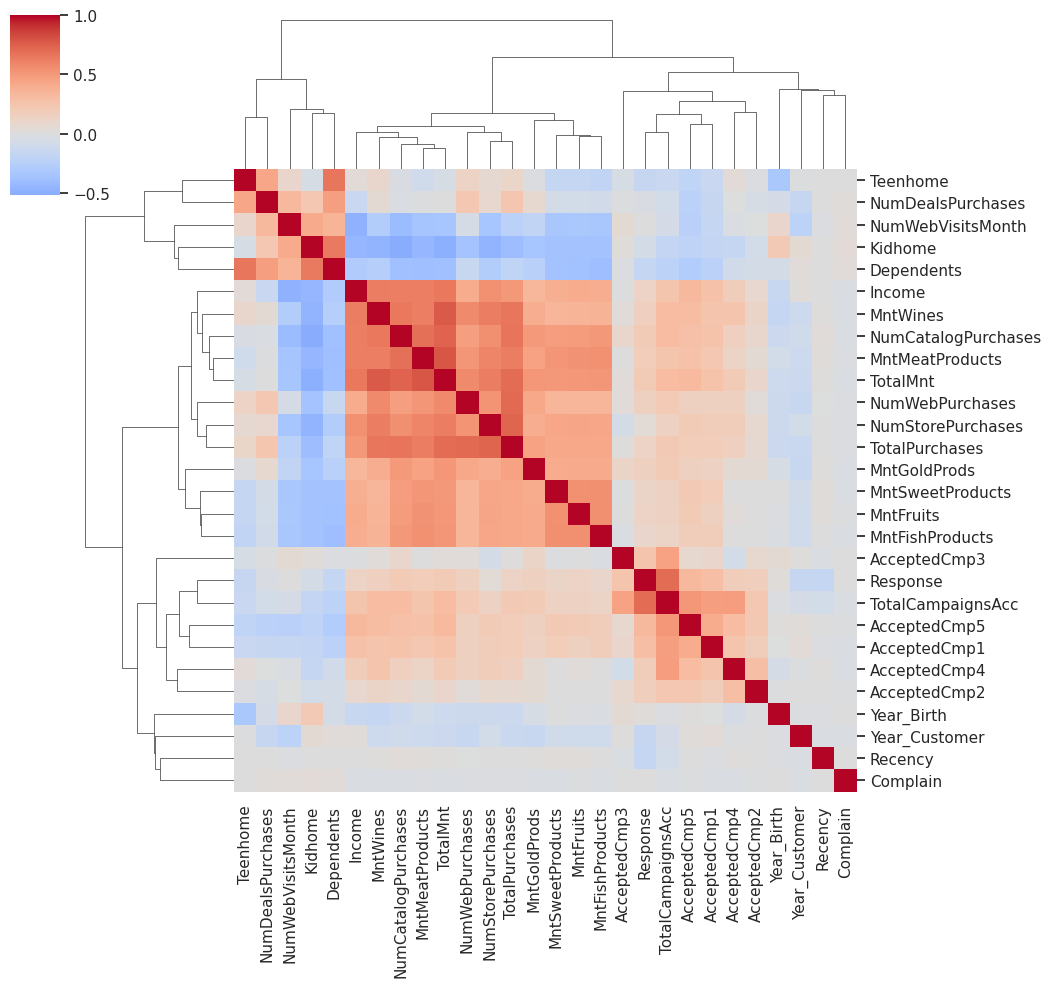

In [16]:
# calculate correlation matrix
## using non-parametric test of correlation (kendall), since some features are binary
corrs = df.drop(columns='ID').select_dtypes(include=np.number).corr(method = 'kendall')

# plot clustered heatmap of correlations
sns.clustermap(corrs, cbar_pos=(-0.05, 0.8, 0.05, 0.18), cmap='coolwarm', center=0);

* Plot illustrating the effect of high income on spending:

Note: For the purposes of this plot, limiting income to < 200000 to remove outlier

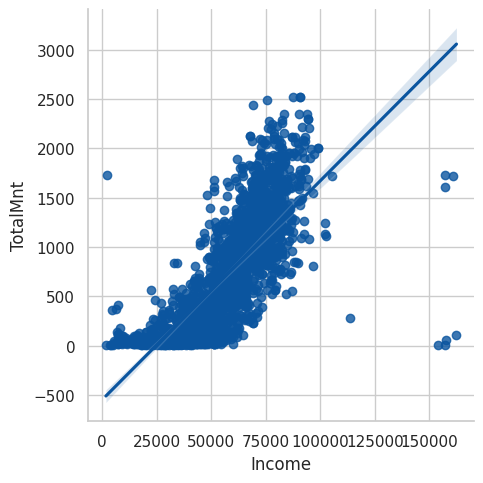

In [17]:
sns.lmplot(x='Income', y='TotalMnt', data=df[df['Income'] < 200000]);

* Plot illustrating negative effect of having dependents (kids & teens) on spending:

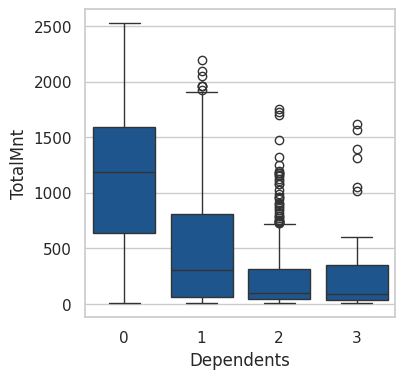

In [18]:
plt.figure(figsize=(4,4))
sns.boxplot(x='Dependents', y='TotalMnt', data=df);

* Plot illustrating positive effect of having dependents (kids & teens) on number of deals purchased:

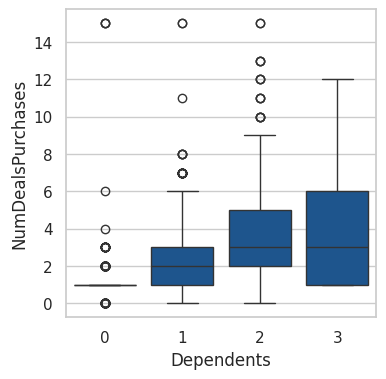

In [19]:
plt.figure(figsize=(4,4))
sns.boxplot(x='Dependents', y='NumDealsPurchases', data=df);

* Plots illustrating the positive effect of income and negative effect of having kids & teens on advertising campaign acceptance:

Note: For the purposes of the following plot, limiting income to < 200000 to remove outlier

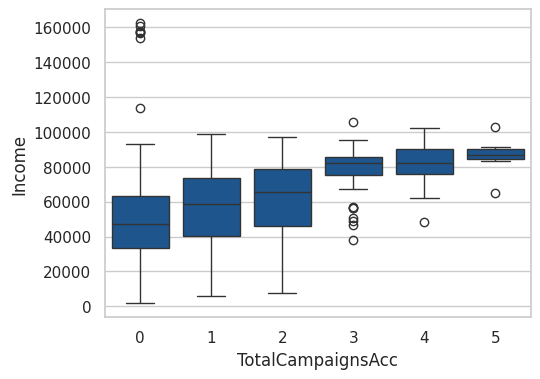

In [20]:
plt.figure(figsize=(5.5,4))
sns.boxplot(x='TotalCampaignsAcc', y='Income', data=df[df['Income']<200000]);

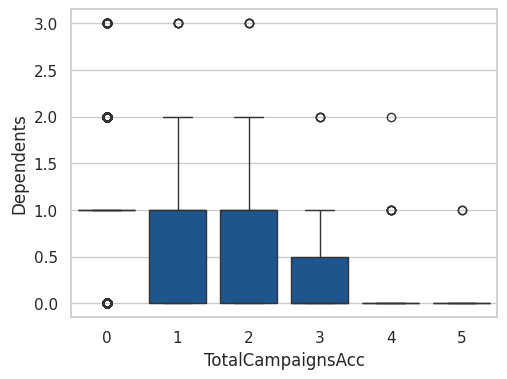

In [21]:
plt.figure(figsize=(5.5,4))
sns.boxplot(x='TotalCampaignsAcc', y='Dependents', data=df);

* Investigate anomaly:
    - Number of web visits in the last month is not positively correlated with number of web purchases
    - Instead, it is positively correlated with the number of deals purchased, suggesting that deals are an effective way of stimulating purchases on the website

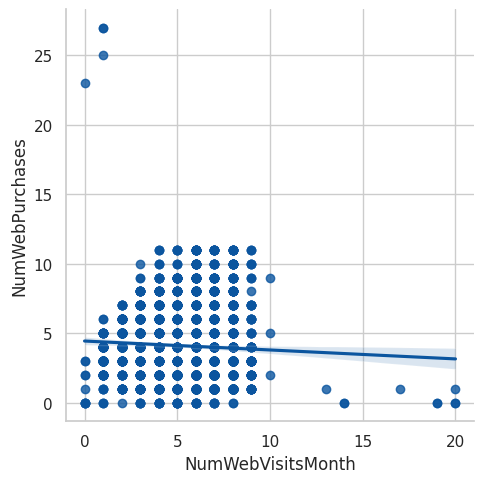

In [22]:
sns.lmplot(x='NumWebVisitsMonth', y='NumWebPurchases', data=df);

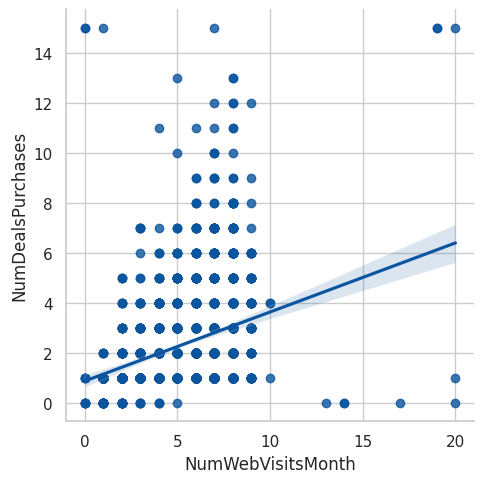

In [23]:
sns.lmplot(x='NumWebVisitsMonth', y='NumDealsPurchases', data=df);

# Section 02: Statistical Analysis

Please run statistical tests in the form of regressions to answer these questions & propose data-driven action recommendations to your CMO. Make sure to interpret your results with non-statistical jargon so your CMO can understand your findings.  

### What factors are significantly related to the number of store purchases?  

* We will use use a linear regression model with `NumStorePurchases` as the target variable, and then use machine learning explainability techniques to get insights about which features predict the number of store purchases
* Begin by plotting the target variable:

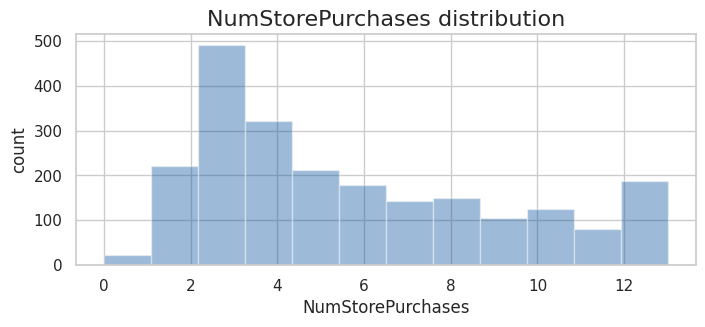

In [24]:
plt.figure(figsize=(8,3))
sns.distplot(df['NumStorePurchases'], kde=False, hist=True, bins=12)
plt.title('NumStorePurchases distribution', size=16)
plt.ylabel('count');

* Drop uninformative features
    - `ID` is unique to each customer
    - `Dt_Customer` will be dropped in favor of using engineered variable `Year_Customer`
* Perform one-hot encoding of categorical features, encoded data shown below:

In [25]:
# drop unique ID
df.drop(columns=['ID', 'Dt_Customer'], inplace=True)

In [26]:
# one-hot encoding of categorical features
from sklearn.preprocessing import OneHotEncoder

# get categorical features and review number of unique values
cat = df.select_dtypes(exclude=np.number)
print("Number of unique values per categorical feature:\n", cat.nunique())

# use one hot encoder
enc = OneHotEncoder(sparse=False).fit(cat)
cat_encoded = pd.DataFrame(enc.transform(cat))
cat_encoded.columns = enc.get_feature_names_out(cat.columns)

# merge with numeric data
num = df.drop(columns=cat.columns)
df2 = pd.concat([cat_encoded, num], axis=1)
df2.head()

Number of unique values per categorical feature:
 Education         5
Marital_Status    8
Country           8
dtype: int64


,Education_2n Cycle,Education_Basic,Education_Graduation,Education_Master,Education_PhD,Marital_Status_Absurd,Marital_Status_Alone,Marital_Status_Divorced,Marital_Status_Married,Marital_Status_Single,Marital_Status_Together,Marital_Status_Widow,Marital_Status_YOLO,Country_AUS,Country_CA,Country_GER,Country_IND,Country_ME,Country_SA,Country_SP,Country_US,Year_Birth,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Response,Complain,Dependents,Year_Customer,TotalMnt,TotalPurchases,TotalCampaignsAcc
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1970,84835.0,0,0,0,189,104,379,111,189,218,1,4,4,6,1,0,0,0,0,0,1,0,0,2014,1190,15,1
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1961,57091.0,0,0,0,464,5,64,7,0,37,1,7,3,7,5,0,0,0,0,1,1,0,0,2014,577,18,2
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1958,67267.0,0,1,0,134,11,59,15,2,30,1,3,2,5,2,0,0,0,0,0,0,0,1,2014,251,11,0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1967,32474.0,1,1,0,10,0,1,0,0,0,1,1,0,2,7,0,0,0,0,0,0,0,2,2014,11,4,0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1989,21474.0,1,0,0,6,16,24,11,0,34,2,3,1,2,7,1,0,0,0,0,1,0,1,2014,91,8,2


* Fit linear regression model to training data (70% of dataset)
* Evaluate predictions on test data (30% of dataset) using RMSE:
    - Findings: The RMSE is exceedingly small compared to the median value of the target variable, indicating good model predictions

In [27]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# isolate X and y variables, and perform train-test split
X = df2.drop(columns='NumStorePurchases')
y = df2['NumStorePurchases']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

# linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# predictions
preds = model.predict(X_test)

# evaluate model using RMSE
print("Linear regression model RMSE: ", np.sqrt(mean_squared_error(y_test, preds)))
print("Median value of target variable: ", y.median())

Linear regression model RMSE:  3.239754174836255e-14
Median value of target variable:  5.0


* Identify features that significantly affect the number of store purchases, using permutation importance:
    - Significant features:
        - 'TotalPurchases', 'NumCatalogPurchases', 'NumWebPurchases', 'NumDealsPurchases'
        - All other features are not significant

In [28]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(model, random_state=1).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = X_test.columns.tolist(), top=5)

* Explore the directionality of these effects, using SHAP values:
    - Findings:
        - The number of store purchases increases with higher number of total purchases ('TotalPurchases')
        - The number of store purchases decreases with higher number of catalog, web, or deals purchases ('NumCatalogPurchases', 'NumWebPurchases', 'NumDealsPurchases')
    - Interpretation:
        - Customers who shop the most in stores are those who shop less via the catalog, website, or special deals

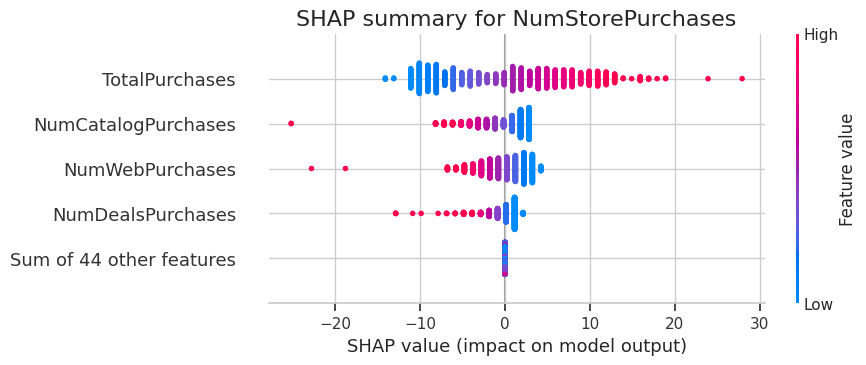

In [29]:
import shap

# calculate shap values
ex = shap.Explainer(model, X_train)
shap_values = ex(X_test)

# plot
plt.title('SHAP summary for NumStorePurchases', size=16)
shap.plots.beeswarm(shap_values, max_display=5);

### Does US fare significantly better than the Rest of the World in terms of total purchases?

* Plot total number of purchases by country:
    - Findings:
        - Spain (SP) has the highest number of purchases
        - US is second to last, therefore the US does not fare better than the rest of the world in terms of the total number of purchases

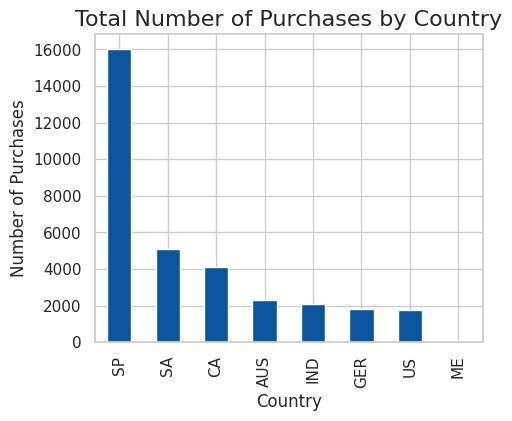

In [30]:
plt.figure(figsize=(5,4))
df.groupby('Country')['TotalPurchases'].sum().sort_values(ascending=False).plot(kind='bar')
plt.title('Total Number of Purchases by Country', size=16)
plt.ylabel('Number of Purchases');

* Plot total amount spent by country:
    - Findings:
        - Spain (SP) has the highest total amount spent on purchases
        - US is second to last, therefore the US does not fare better than the rest of the world in terms of the total amount spent on purchases

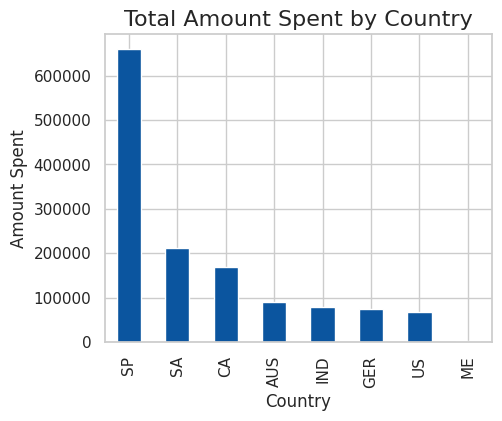

In [31]:
plt.figure(figsize=(5,4))
df.groupby('Country')['TotalMnt'].sum().sort_values(ascending=False).plot(kind='bar')
plt.title('Total Amount Spent by Country', size=16)
plt.ylabel('Amount Spent');

### Your supervisor insists that people who buy gold are more conservative. Therefore, people who spent an above average amount on gold in the last 2 years would have more in store purchases. Justify or refute this statement using an appropriate statistical test

* Plot relationship between amount spent on gold in the last 2 years (`MntGoldProds`) and number of in store purchases (`NumStorePurchases`):
    - Findings: There is a positive relationship, but is it statistically significant?

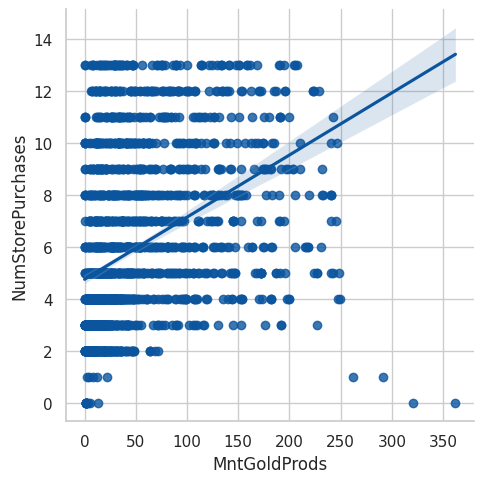

In [32]:
sns.lmplot(x='MntGoldProds', y='NumStorePurchases', data = df);

* Perform Kendall correlation analysis (non-parametric test since `MntGoldProducts` is not normally distributed and contains outliers):
    - Findings: There is significant positive correlation between `MntGoldProds` and `NumStorePurchases`

In [33]:
from scipy.stats import kendalltau

kendall_corr = kendalltau(x=df['MntGoldProds'], y=df['NumStorePurchases'])

# print results
print('Kendall correlation (tau): ', kendall_corr.correlation)
print('Kendall p-value: ', kendall_corr.pvalue)

Kendall correlation (tau):  0.3927160395725131
Kendall p-value:  3.55881817905435e-152


### Fish has Omega 3 fatty acids which are good for the brain. Accordingly, do "Married PhD candidates" have a significant relation with amount spent on fish?

* We will compare `MntFishProducts` between Married PhD candidates and all other customers:
    - Findings: Married PhD candidates spend significantly less on fish products compared to other customers.

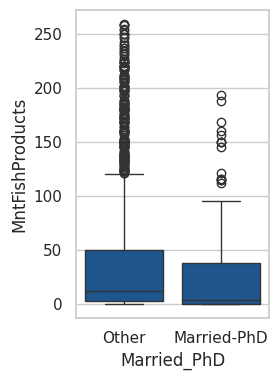

In [34]:
# sum the marital status and phd dummy variables - the Married+PhD group will have value of 2
df2['Married_PhD'] = df2['Marital_Status_Married'] + df2['Education_PhD']
df2['Married_PhD'] = df2['Married_PhD'].replace({2:'Married-PhD', 1:'Other', 0:'Other'})

# plot MntFishProducts between Married-PhD and others
plt.figure(figsize=(2.5,4))
sns.boxplot(x='Married_PhD', y='MntFishProducts', data=df2);

In [35]:
# independent t-test p-value
from scipy.stats import ttest_ind
pval = ttest_ind(df2[df2['Married_PhD'] == 'Married-PhD']['MntFishProducts'], df2[df2['Married_PhD'] == 'Other']['MntFishProducts']).pvalue
print("t-test p-value: ", round(pval, 3))

t-test p-value:  0.005


In [36]:
# now drop the married-phD column created above, to include only the original variables in the analysis below
df2.drop(columns='Married_PhD', inplace=True)

### What other factors are significantly related to amount spent on fish?

* Like with the analysis of `NumStorePurchases` above, we will use use a linear regression model with `MntFishProducts` as the target variable, and then use machine learning explainability techniques to get insights about which features predict the amount spent on fish
* Begin by plotting the target variable:

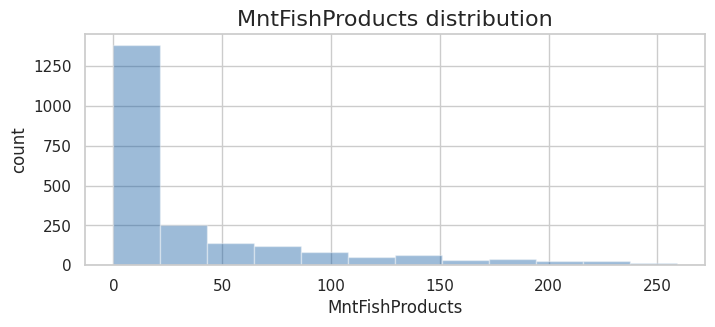

In [37]:
plt.figure(figsize=(8,3))
sns.distplot(df['MntFishProducts'], kde=False, hist=True, bins=12)
plt.title('MntFishProducts distribution', size=16)
plt.ylabel('count');

* Fit linear regression model to training data (70% of dataset)
* Evaluate predictions on test data (30% of dataset) using RMSE:
    - Findings: The RMSE is exceedingly small compared to the median value of the target variable, indicating good model predictions

In [38]:
# isolate X and y variables, and perform train-test split
X = df2.drop(columns='MntFishProducts')
y = df2['MntFishProducts']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

# linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# predictions
preds = model.predict(X_test)

# evaluate model using RMSE
print("Linear regression model RMSE: ", np.sqrt(mean_squared_error(y_test, preds)))
print("Median value of target variable: ", y.median())

Linear regression model RMSE:  6.148798766767868e-13
Median value of target variable:  12.0


* Identify features that significantly affect the amount spent on fish, using permutation importance:
    - Significant features:
        - 'TotalMnt', 'MntWines', 'MntMeatProducts', 'MntGoldProds', 'MntSweetProducts', 'MntFruits'
        - All other features are not significant

In [39]:
perm = PermutationImportance(model, random_state=1).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = X_test.columns.tolist(), top=7)

* Explore the directionality of these effects, using SHAP values:
    - Findings:
        - The amount spent on fish increases with higher total amount spent ('TotalMnt')
        - The amount spent on fish decreases with higher amounts spent on wine, meat, gold, fruit, or sweets ('MntWines', 'MntMeatProducts', 'MntGoldProds', 'MntSweetProducts', 'MntFruits')
    - Interpretation:
        - Customers who spend the most on fish are those who spend less on other products (wine, meat, gold, fruit, and sweets)

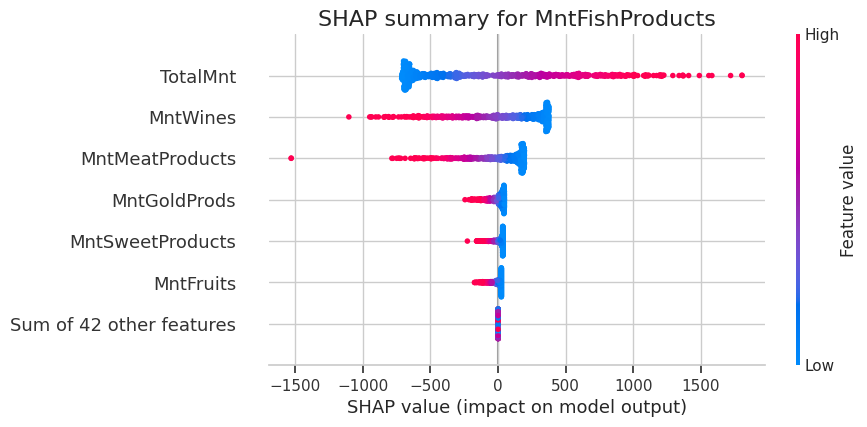

In [40]:
import shap

# calculate shap values
ex = shap.Explainer(model, X_train)
shap_values = ex(X_test)

# plot
plt.title('SHAP summary for MntFishProducts', size=16)
shap.plots.beeswarm(shap_values, max_display=7);

### Is there a significant relationship between geographical regional and success of a campaign?

* Plot success of campaigns by region:
    - Findings:
        - The campaign acceptance rates are low overall
        - The campaign with the highest overall acceptance rate is the most recent campaign (column name: `Response`)
        - The country with the highest acceptance rate in any campaign is Mexico
    - Is the effect of region on campaign success statistically significant? See below.

In [41]:
# convert country codes to correct nomenclature for choropleth plot
# the dataset doesn't provide information about country codes
## ...so I'm taking my best guess about the largest nations that make sense given the codes provided
df['Country_code'] = df['Country'].replace({'SP': 'ESP', 'CA': 'CAN', 'US': 'USA', 'SA': 'ZAF', 'ME': 'MEX'})

# success of campaigns by country code
df_cam = df[['Country_code', 'AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'Response']].melt(
    id_vars='Country_code', var_name='Campaign', value_name='Accepted (%)')
df_cam = pd.DataFrame(df_cam.groupby(['Country_code', 'Campaign'])['Accepted (%)'].mean()*100).reset_index(drop=False)

# rename the campaign variables so they're easier to interpret
df_cam['Campaign'] = df_cam['Campaign'].replace({'AcceptedCmp1': '1',
                                                'AcceptedCmp2': '2',
                                                'AcceptedCmp3': '3',
                                                'AcceptedCmp4': '4',
                                                'AcceptedCmp5': '5',
                                                 'Response': 'Most recent'
                                                })

# choropleth plot
import plotly.express as px

fig = px.choropleth(df_cam, locationmode='ISO-3', color='Accepted (%)', facet_col='Campaign', facet_col_wrap=2,
                    facet_row_spacing=0.05, facet_col_spacing=0.01, width=700,
                    locations='Country_code', projection='natural earth', title='Advertising Campaign Success Rate by Country'
                   )
fig.show()

* Statistical summary of regional effects on campaign success:
    - Methodology: Performed logistic regression for Campaign Accepted by Country, reporting Chisq p-value for overall model.
    - Findings: The regional differences in advertising campaign success are statistically significant.

In [42]:
# calculate logistic regression p-values for campaign acceptance ~ country using generalized linear model
import statsmodels.formula.api as smf
import statsmodels as sm
from scipy import stats

## get the data of interest for glm
df_cam_wide = df[['Country', 'AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'Response']]

## to store statistics results
stat_results = []

## perform glm
for col in df_cam_wide.drop(columns='Country').columns:
    this_data = df_cam_wide[['Country', col]]

    # define formula
    formula = col+'~Country'

    # logistic regression (family=binomial)
    model = smf.glm(formula = formula, data=this_data, family=sm.genmod.families.Binomial())
    result = model.fit()

    # get chisquare value for overall model (CampaignAccepted ~ Country) and calculate p-value
    chisq = result.pearson_chi2
    pval = stats.distributions.chi2.sf(chisq , 7) # Df Model = 7 degrees of freedom when you run result.summary()

    # append to stat_results
    stat_results.append(pval)

    # print stat summary for entire model
    print(result.summary())

## check results
print("\nChisq p-values: ", stat_results)

                 Generalized Linear Model Regression Results                  
Dep. Variable:           AcceptedCmp1   No. Observations:                 2237
Model:                            GLM   Df Residuals:                     2229
Model Family:                Binomial   Df Model:                            7
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -532.52
Date:                Mon, 29 Jan 2024   Deviance:                       1065.0
Time:                        05:15:56   Pearson chi2:                 2.23e+03
No. Iterations:                    20   Pseudo R-squ. (CS):           0.001563
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -3.0845      0.387     -7.

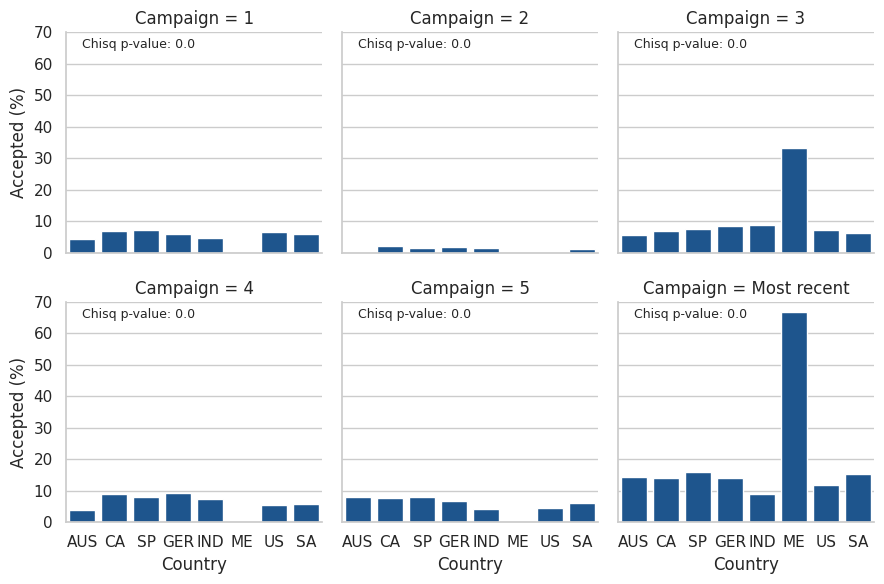

In [43]:
# plotting
## merge in the original country codes provided in the dataset
countries = df[['Country', 'Country_code']].drop_duplicates().reset_index(drop=True)
df_cam2 = df_cam.merge(countries, how='left', on='Country_code')
df_cam2.head()

## bar graphs
g = sns.FacetGrid(df_cam2, col='Campaign', col_wrap=3)
g.map(sns.barplot, 'Country', 'Accepted (%)')
for ax, pval in zip(g.axes.flat, stat_results):
    ax.text(0, 65, "Chisq p-value: "+str(pval), fontsize=9) #add text;

# Section 03: Data Visualization

Please plot and visualize the answers to the below questions.

### Which marketing campaign is most successful?

* Plot marketing campaign overall acceptance rates:
    - Findings: The most successful campaign is the most recent (column name: `Response`)

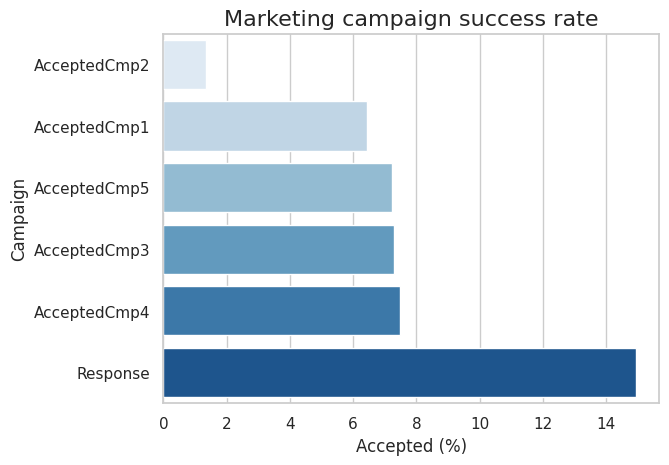

In [44]:
# calculate success rate (percent accepted)
cam_success = pd.DataFrame(df[['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'Response']].mean()*100,
                           columns=['Percent']).reset_index()

# plot
sns.barplot(x='Percent', y='index', data=cam_success.sort_values('Percent'), palette='Blues')
plt.xlabel('Accepted (%)')
plt.ylabel('Campaign')
plt.title('Marketing campaign success rate', size=16);

### What does the average customer look like for this company?

* Basic demographics: The average customer is...
    - Born in 1969
    - Became a customer in 2013
    - Has an income of roughly \$52,000 per year
    - Has 1 dependent (roughly equally split between kids or teens)
    - Made a purchase from our company in the last 49 days

In [45]:
# list of cols with binary responses
binary_cols = [col for col in df.columns if 'Accepted' in col] + ['Response', 'Complain']

# list of cols for spending
mnt_cols = [col for col in df.columns if 'Mnt' in col]

# list of cols for channels
channel_cols = [col for col in df.columns if 'Num' in col] + ['TotalPurchases', 'TotalCampaignsAcc']

In [46]:
# average customer demographics
demographics = pd.DataFrame(round(df.drop(columns=binary_cols+mnt_cols+channel_cols).mean(), 1), columns=['Average']).reindex([
    'Year_Birth', 'Year_Customer', 'Income', 'Dependents', 'Kidhome', 'Teenhome', 'Recency'])

demographics

,Average
Year_Birth,1968.9
Year_Customer,2013.0
Income,52227.4
Dependents,1.0
Kidhome,0.4
Teenhome,0.5
Recency,49.1


### Which products are performing best?

* The average customer spent...
    - \$25-50 on Fruits, Sweets, Fish, or Gold products
    - Over \$160 on Meat products
    - Over \$300 on Wines
    - Over \$600 total
* Products performing best:
    - Wines
    - Followed by meats

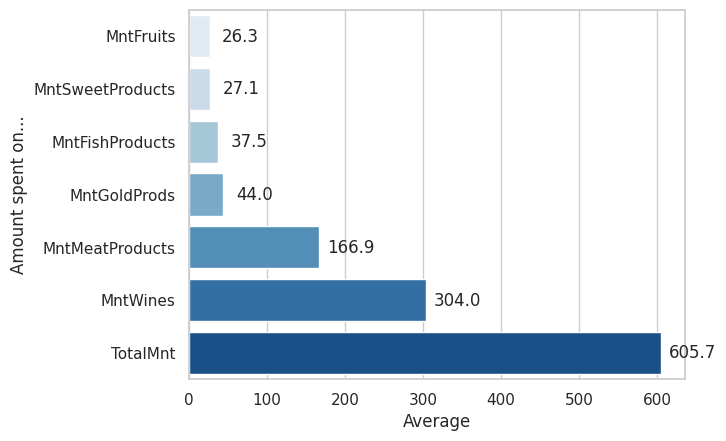

In [47]:
spending = pd.DataFrame(round(df[mnt_cols].mean(), 1), columns=['Average']).sort_values(by='Average').reset_index()

# plot
ax = sns.barplot(x='Average', y='index', data=spending, palette='Blues')
plt.ylabel('Amount spent on...')

## add text labels for each bar's value
for p,q in zip(ax.patches, spending['Average']):
    ax.text(x=q+40,
            y=p.get_y()+0.5,
            s=q,
            ha="center") ;

### Which channels are underperforming?

* Channels: The average customer...
    - Accepted less than 1 advertising campaign
    - Made 2 deals purchases, 2 catalog purchases, 4 web purchases, and 5 store purchases
    - Averaged 14 total purchases
    - Visited the website 5 times
* Underperforming channels:
    - Advertising campaigns
    - Followed by deals, and catalog

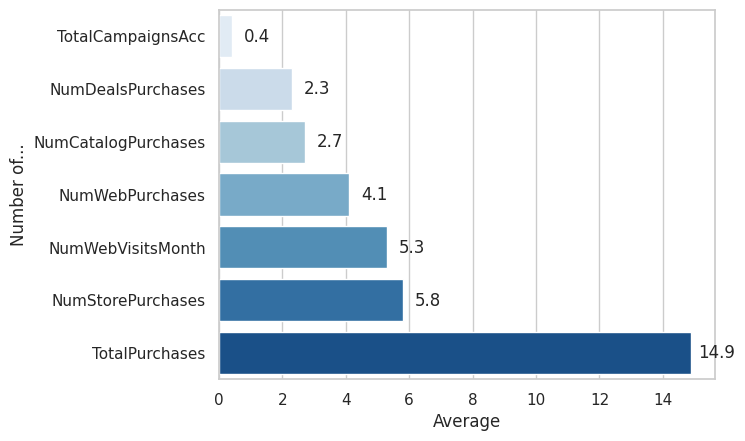

In [48]:
channels = pd.DataFrame(round(df[channel_cols].mean(), 1), columns=['Average']).sort_values(by='Average').reset_index()

# plot
ax = sns.barplot(x='Average', y='index', data=channels, palette='Blues')
plt.ylabel('Number of...')

## add text labels for each bar's value
for p,q in zip(ax.patches, channels['Average']):
    ax.text(x=q+0.8,
            y=p.get_y()+0.5,
            s=q,
            ha="center") ;

# Conclusion



**Summary of actionable findings to improve advertising campaign success:**  
* The most successful advertising campaign was the most recent campaign (column name: `Response`), and was particularly successful in Mexico (>60% acceptance rate!)
    - Suggested action: Conduct future advertising campaigns using the same model recently implemented in Mexico.
* Advertising campaign acceptance is positively correlated with income and negatively correlated with having kids/teens
    - Suggested action: Create two streams of targeted advertising campaigns, one aimed at high-income individuals without kids/teens and another aimed at lower-income individuals with kids/teens
* The most successful products are wines and meats (*i.e.* the average customer spent the most on these items)
    - Suggested action: Focus advertising campaigns on boosting sales of the less popular items
* The underperforming channels are deals and catalog purchases (*i.e.* the average customer made the fewest purchases via these channels)
* The best performing channels are web and store purchases (*i.e.* the average customer made the most purchases via these channels)
    - Suggested action: Focus advertising campaigns on the more successful channels, to reach more customers